## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

  Using cached nlp-0.4.0-py3-none-any.whl (1.7 MB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [6]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [7]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [9]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [15]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data] 
    return tweets,labels

In [16]:
tweets,labels = get_tweet(train)

In [17]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [21]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [22]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

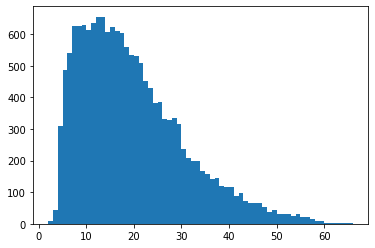

In [32]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [33]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
def get_sequences(tokenizer,tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding = 'post',maxlen=maxlen)
    return padded

In [35]:
padded_train_seq = get_sequences(tokenizer,tweets)

In [38]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [40]:
classes = set(labels)
print(classes)

{'surprise', 'sadness', 'love', 'fear', 'joy', 'anger'}


(array([4666.,    0., 2159.,    0., 1304.,    0.,  572.,    0., 1937.,
           0., 5362.]),
 array([0.        , 0.45454545, 0.90909091, 1.36363636, 1.81818182,
        2.27272727, 2.72727273, 3.18181818, 3.63636364, 4.09090909,
        4.54545455, 5.        ]),
 <BarContainer object of 11 artists>)

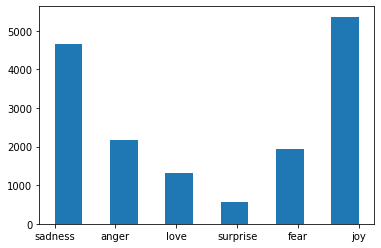

In [46]:
plt.hist(labels,bins=11)

In [47]:
class_to_index = dict((c, i ) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [48]:
class_to_index

{'surprise': 0, 'sadness': 1, 'love': 2, 'fear': 3, 'joy': 4, 'anger': 5}

In [49]:
index_to_class

{0: 'surprise', 1: 'sadness', 2: 'love', 3: 'fear', 4: 'joy', 5: 'anger'}

In [50]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [53]:
train_labels = names_to_ids(labels)
print(labels[0])
print(train_labels[0])

sadness
1


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']

)

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            12544     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 197,766
Trainable params: 197,766
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [56]:
val_tweets,val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_ids(val_labels)


In [57]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [59]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 15s 24ms/step - loss: 1.3449 - accuracy: 0.4320 - val_loss: 1.0209 - val_accuracy: 0.6015
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.6994 - accuracy: 0.7273 - val_loss: 0.5828 - val_accuracy: 0.8120
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3572 - accuracy: 0.8787 - val_loss: 0.4546 - val_accuracy: 0.8460
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2380 - accuracy: 0.9252 - val_loss: 0.4481 - val_accuracy: 0.8585
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.1769 - accuracy: 0.9421 - val_loss: 0.3757 - val_accuracy: 0.8835
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.1407 - accuracy: 0.9546 - val_loss: 0.3835 - val_accuracy: 0.8910
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.1067 - accuracy: 0.9670 - val_loss: 0.4168 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

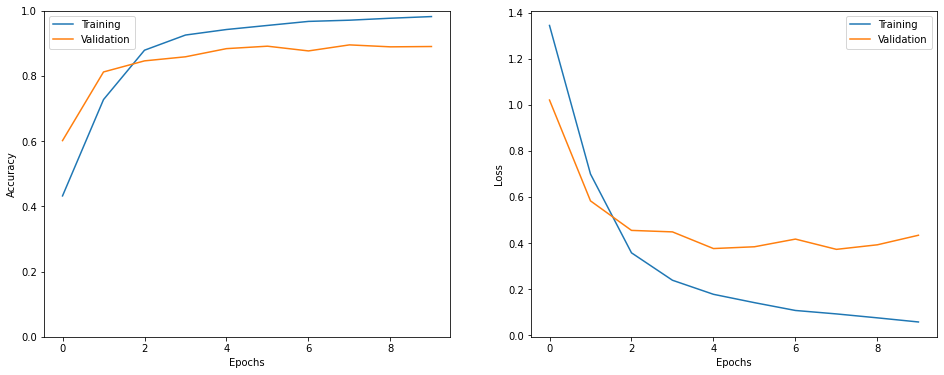

In [60]:
show_history(h)

In [61]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [62]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4294 - accuracy: 0.8945


In [83]:
i = random.randint(0,len(test_labels)-1)
print('Sentence: ',test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]

pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted: ',pred_class)

Sentence:  i also feel the need to mention that the animators at pixar sure outdid themselves this time
Emotion:  joy
Predicted:  joy


In [94]:
preds = model.predict(test_seq)
preds = np.array([np.argmax(i) for i in preds])

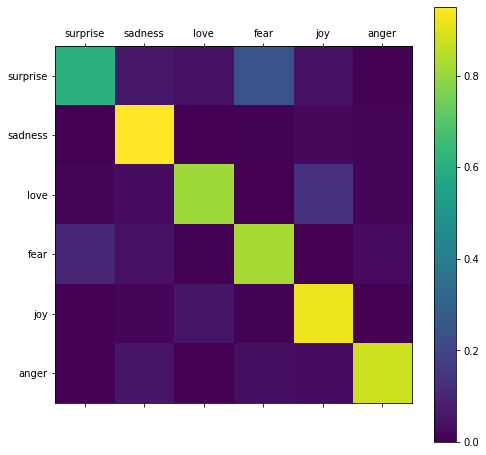

In [95]:
show_confusion_matrix(test_labels,preds,list(classes))